In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

/Users/yeeeeehan/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# read in dataset and select columns
terror = pd.read_csv('../../terrorism_new.csv')

cols = [
    'success','eventid','extended',
    'attacktype1_txt','weaptype1_txt','targtype1_txt',
    'claimed','gname','suicide','nperps',
    'nkill','nwound','property','propextent','propvalue'
]

numeric_cols = [
    'nkill','nwound','nperps','propvalue'
]

/Users/yeeeeehan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# herlper functions
unknown_map = {
    # TODO: update as i go along
    "nperps":-99,
    "propvalue":-99,
}


def filterColumnsAndRows(df, cols, mapping):
    df = df[cols].dropna()
    for col in cols:
        if col in mapping:
            df = df[df[col] != mapping[col]]
    return df

def getDendrogram(features):
    plt.figure(figsize=(10, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(features, method='ward'))
    
def getClusterStats(features, num_clusters, cols):
    cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
    features['cluster'] =  cluster.fit_predict(features)
    feature_stats = features.groupby('cluster')[cols].mean()
    ax = sns.heatmap(feature_stats)
    return features, feature_stats

def plotHistogramForCluster(df, cluster, col):
    df = df[df['cluster'] == cluster]\
    .groupby(col)['eventid']\
    .count()\
    .to_frame()\
    .reset_index()\
    .sort_values('eventid',ascending=False)

    plt.figure(figsize=(20,10))

    df_plot = sns.barplot(x=col, y="eventid", palette="rocket", data=df)
    for item in df_plot.get_xticklabels():
        item.set_rotation(45)
    plt.title(f"Distribution of {col} for cluster {cluster}")

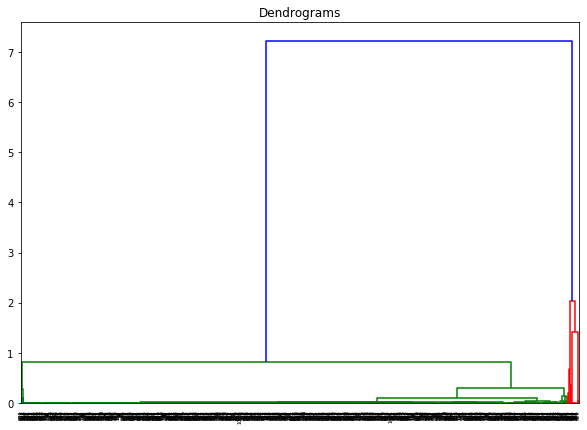

In [8]:
df = filterColumnsAndRows(terror, numeric_cols + ['eventid'], unknown_map)
features = pd.DataFrame(normalize(df[numeric_cols]),columns = numeric_cols)
getDendrogram(features)

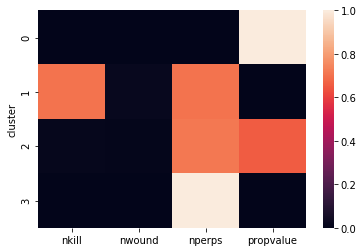

In [9]:
features, feature_stats = getClusterStats(features, 4, ['nkill','nwound','nperps','propvalue'])

In [10]:
features['cluster'].value_counts()

0    983
3     11
2      6
1      2
Name: cluster, dtype: int64

In [11]:
df['cluster'] = features['cluster'].values

In [12]:
clusters = df[['eventid','cluster']].merge(terror[cols], on = 'eventid')

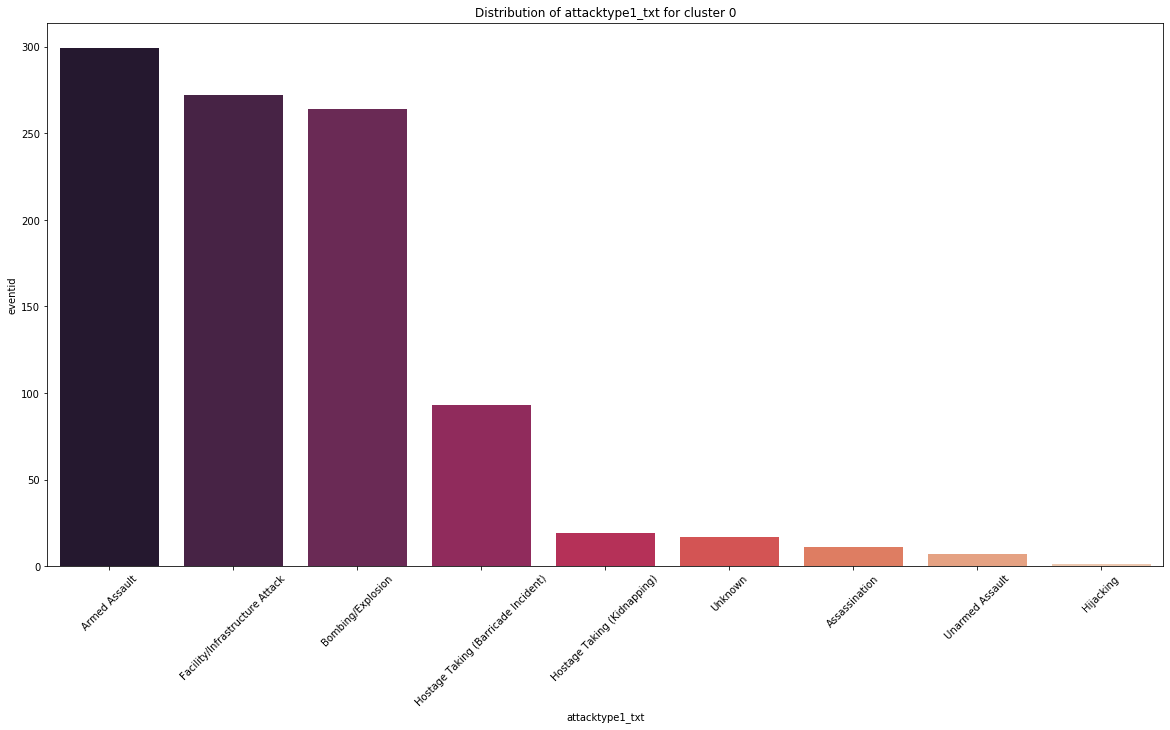

In [13]:
plotHistogramForCluster(clusters, 0, "attacktype1_txt")

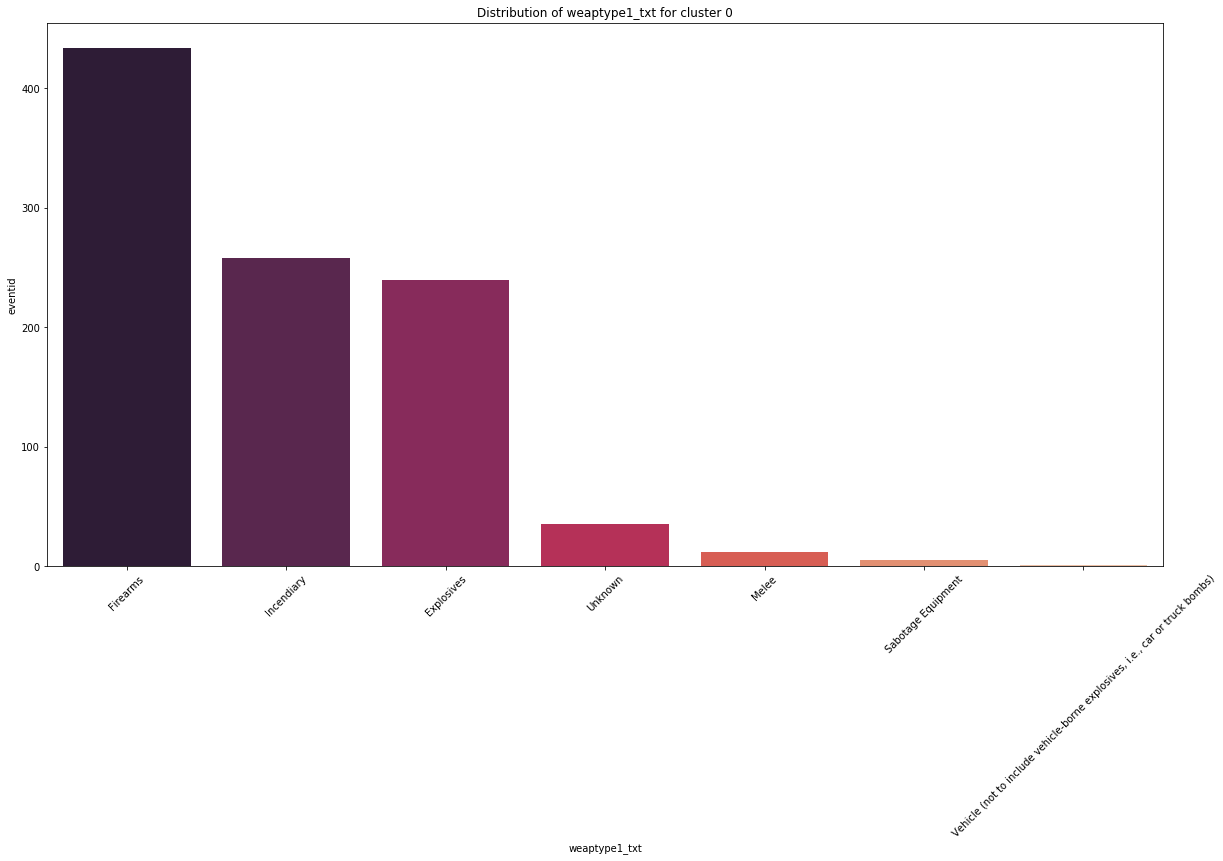

In [14]:
plotHistogramForCluster(clusters, 0, "weaptype1_txt")

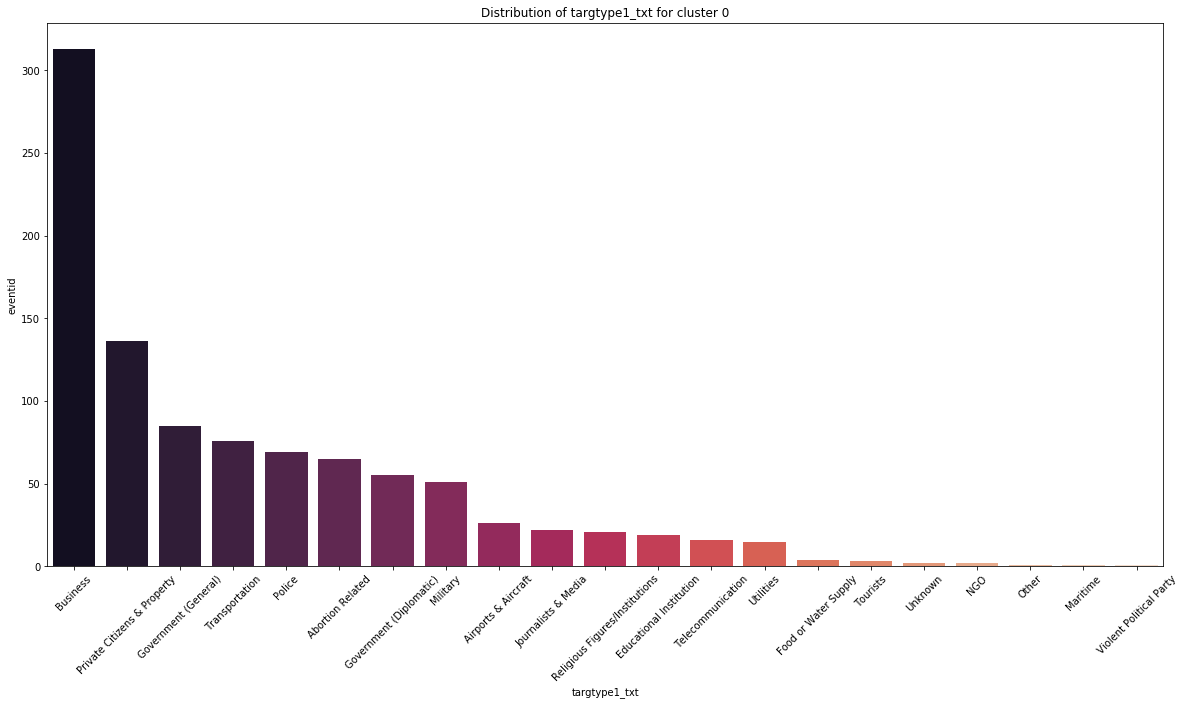

In [15]:
plotHistogramForCluster(clusters, 0, "targtype1_txt")

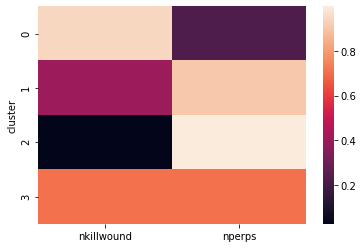

In [16]:
df2 = filterColumnsAndRows(terror, ['eventid','nkill', 'nwound', 'nperps'], unknown_map)
df2['nkillwound'] = df2['nkill'] + df2['nwound']
features2 = pd.DataFrame(normalize(df2[['nkillwound', 'nperps']]),columns = ['nkillwound', 'nperps'])
features2, feature_stats2 = getClusterStats(features2, 4, ['nkillwound', 'nperps'])

RecursionError: maximum recursion depth exceeded while getting the str of an object

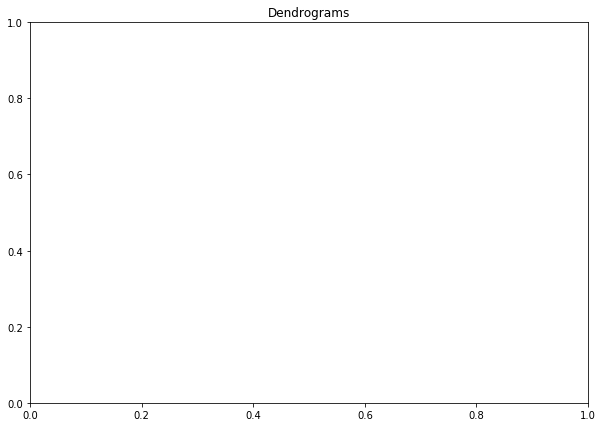

In [20]:
getDendrogram(features2)

In [ ]:
features2['cluster'].value_counts()

In [236]:
df2['cluster'] = features2['cluster'].values
clusters2 = df2[['eventid','cluster']].merge(terror[cols], on = 'eventid')

In [276]:
def plotStackedBar(df, col, num_clusters):
    plt.figure(figsize=(20,10))
    df = df[['eventid',col,'cluster']]\
    .groupby([col,"cluster"])['eventid']\
    .count()\
    .to_frame()\
    .reset_index()
    df = pd.pivot_table(df,values='eventid',index=[col],columns=['cluster'])
    df.columns = [str(i) for i in range(num_clusters)]

    labels = list(df.index)
    idx = np.arange(len(labels))
    total = [sum(arr) for arr in zip(*[df[str(i)] for i in range(num_clusters)])]
    plt.figure(figsize=(20,10))
    width = 0.85
    colors = ['#F8B195','#F67280','#C06C84','#355C7D']
    bars = [[j / k * 100 for j,k in zip(df[str(i)], total)] for i in range(num_clusters)]
    bottom = np.zeros(len(labels))
    for i in range(num_clusters):
        plt.bar(idx, bars[i], bottom=bottom, color=colors[i], edgecolor='white', width=width,label=f'cluster {i}')
        bottom += bars[i]
    plt.xticks(idx, labels, rotation=45)
    plt.xlabel(col)
    plt.ylabel("Proportion")
    plt.legend()
    plt.show()

<Figure size 1440x720 with 0 Axes>

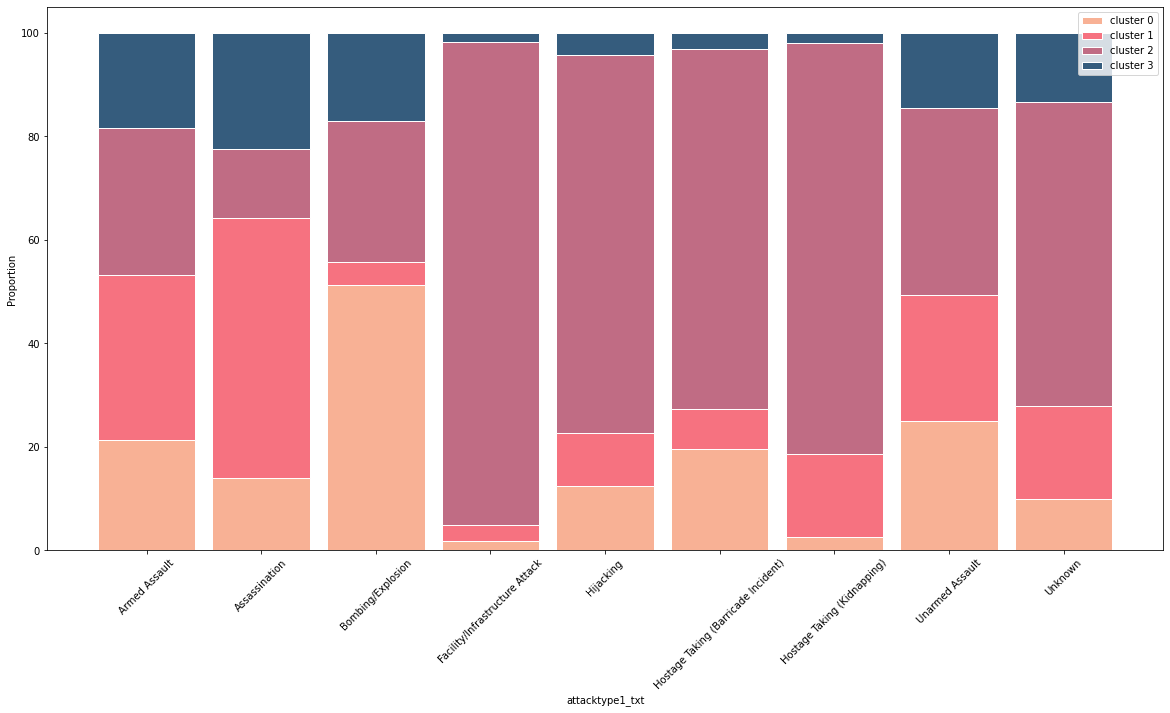

In [277]:
plotStackedBar(clusters2, "attacktype1_txt", 4)

<Figure size 1440x720 with 0 Axes>

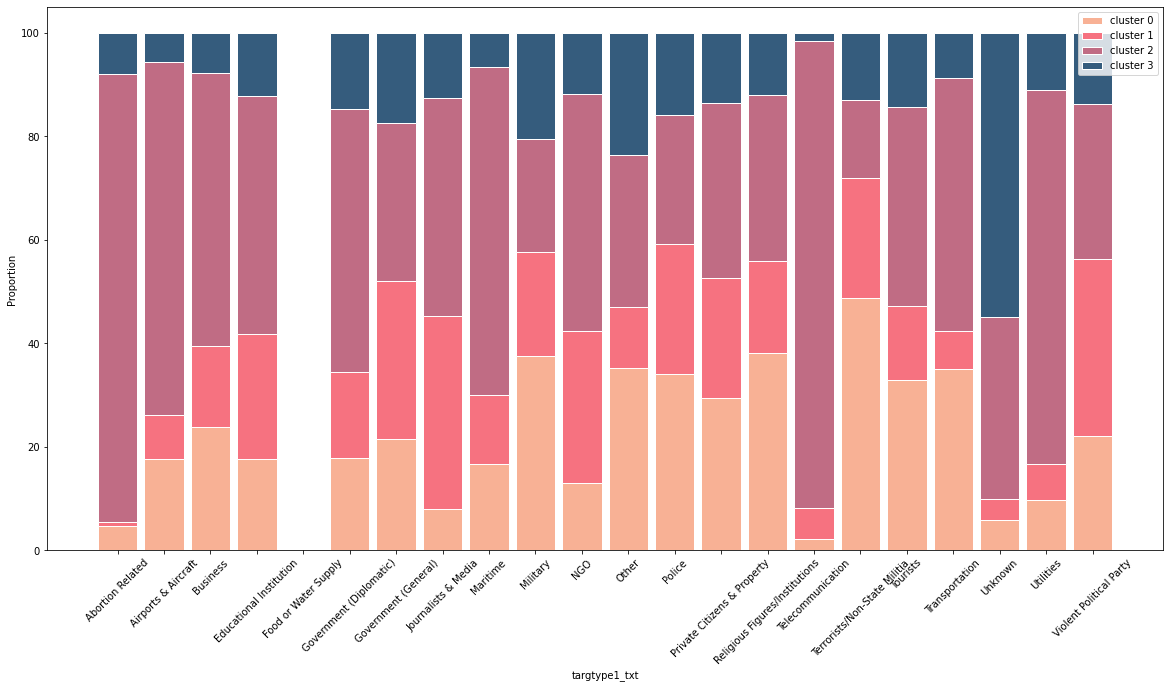

In [279]:
plotStackedBar(clusters2, "targtype1_txt", 4)

In [293]:
clusters2

eventid  cluster  success  extended  \
0      197000000002        2        1         0   
1      197001020001        2        0         0   
2      197001020003        2        1         0   
3      197001030001        2        1         0   
4      197001080001        2        1         0   
...             ...      ...      ...       ...   
28134  201812310012        0        1         0   
28135  201812310019        0        0         0   
28136  201812310020        2        0         0   
28137  201812310023        2        1         0   
28138  201812310025        3        1         0   

                      attacktype1_txt weaptype1_txt            targtype1_txt  \
0         Hostage Taking (Kidnapping)       Unknown  Government (Diplomatic)   
1                       Assassination      Firearms                   Police   
2      Facility/Infrastructure Attack    Incendiary                 Military   
3      Facility/Infrastructure Attack    Incendiary     Government (General)   
4                           Hijacking      Firearms      Airports & Aircraft   
...                               ...           ...                      ...   
28134                   Armed Assault         Melee           Transportation   
28135                   Assassination      Firearms                   Police   
28136                   Assassination      Firearms     Government (General)   
28137                   Armed Assault    Explosives                   Police   
28138               Bombing/Explosion    Explosives                  Unknown   

       claimed                                  gname  suicide  nperps  nkill  \
0          NaN     23rd of September Communist League        0     7.0    0.0   
1          NaN                    Tupamaros (Uruguay)        0     3.0    0.0   
2          1.0                        New Year's Gang        0     1.0    0.0   
3          0.0                        New Year's Gang        0     1.0    0.0   
4          NaN                                Unknown        0     1.0    0.0   
...        ...                                    ...      ...     ...    ...   
28134      1.0             Jihadi-inspired extremists        0     1.0    0.0   
28135      0.0                                Unknown        0     3.0    0.0   
28136      0.0                            Separatists        0    20.0    0.0   
28137      0.0        Mujahidin Indonesia Timur (MIT)        0    12.0    0.0   
28138      0.0  Khorasan Chapter of the Islamic State        0     3.0    3.0   

       nwound  property  propextent  propvalue  
0         0.0         0         NaN        NaN  
1         0.0         0         NaN        NaN  
2         0.0         1         3.0    60000.0  
3         0.0         1         3.0        NaN  
4         0.0         0         NaN        NaN  
...       ...       ...         ...        ...  
28134     3.0         0         NaN        NaN  
28135     5.0         1         3.0      -99.0  
28136     1.0         0         NaN        NaN  
28137     2.0         0         NaN        NaN  
28138     0.0         0         NaN        NaN  

[28139 rows x 16 columns]